In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import networkx as nx
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from datetime import timedelta
import network_build
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


/Users/antoine/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [77]:
def load_data(date):
    SP = pd.read_csv("./Database/SP_60_30_%s.csv" % date, index_col=0)

    # Use of chunk size because a problem of memory

    chunk_size = 10000 
    chunks_iterator = pd.read_csv("./Database/order_clean_260.csv",index_col=0, chunksize=chunk_size)
    chunks=[]
    for chunk in chunks_iterator:
        chunks.append(chunk)
    order = pd.concat(chunks)
    order["call_time"] = pd.to_datetime(order["call_time"])
    order["end_time"] = pd.to_datetime(order["end_time"])
    start_time = pd.to_datetime(date + " 06:00:00 AM")
    end_time = pd.to_datetime(date + " 12:00:00 PM")
    order_one_day = order[(order["call_time"] >= start_time) & (order["call_time"] < end_time)]

    SP.columns = ["SP"]
    SP = SP.reset_index(drop=True)
    order_one_day = order_one_day.sort_values(by="call_time").reset_index(drop=True)


    # the length of the three dataframes should be the same
    assert len(order_one_day) ==  len(SP)

    assert SP.index.equals(order_one_day.index)


    dz = pd.concat([order_one_day, SP], axis=1).dropna()
    nodes_feature = dz[dz['call_time']<pd.to_datetime(date + " 11:00:00 AM")]
    labels = nodes_feature.pop('SP')

    # change date time into seconds between 6 am and the current time

    call_list = nodes_feature["call_time"]
    call_num = [(ts.timestamp()-start_time.timestamp())/3600 for ts in call_list]

    nodes_feature[ "call_time"] = call_num

    end_list = nodes_feature["end_time"]
    end_num = [(ts.timestamp()-start_time.timestamp())/3600 for ts in end_list]
    nodes_feature["end_time"] = end_num

    time_left = 1 - (nodes_feature["end_time"] - nodes_feature["call_time"])
    nodes_feature['time_left'] = time_left

    try_data = nodes_feature.copy()
    try_data = try_data[['eid','end_time','time_left']]

    labels = labels-1
    
    return try_data,labels

In [62]:
def plot_results(model,X_test,y_test):
    y_pred = model.predict(X_test)

    max_depth = model.get_params()['max_depth']
    lr = model.get_params()['learning_rate']
    n_estimators = model.get_params()['n_estimators']

    accuracy = accuracy_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_pred,y_test)
    plt.figure(figsize=(14,8))
    plt.scatter(y_pred,y_test,color='b',alpha=0.1)
    plt.plot(y_pred,y_pred,color='r')
    plt.xlabel('SP pred')
    plt.ylabel('SP target')
    plt.text(0.20, 0.95, f'R2 = {r2:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
    plt.text(0.20, 0.90, f'MAE = {mae:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
    plt.text(0.20, 0.85, f'ACCURACY = {accuracy:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
    plt.text(0.85, 0.25, f'lr = {lr:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
    plt.text(0.85, 0.20, f'n_estimator = {n_estimator}', transform=plt.gca().transAxes, va='top', ha='left')
    plt.text(0.85, 0.15, f'max_depth = {max_depth}', transform=plt.gca().transAxes, va='top', ha='left')
    plt.show()

# First Try

In [2]:
date = "2022-06-01"
network_metrics = pd.read_csv("./Database/network_metrics_%s.csv" % date, index_col=0)
SP = pd.read_csv("./Database/SP_60_%s.csv" % date, index_col=0)

# Use of chunk size because a problem of memory

chunk_size = 10000 
chunks_iterator = pd.read_csv("./Database/order_clean_260.csv",index_col=0, chunksize=chunk_size)
chunks=[]
for chunk in chunks_iterator:
    chunks.append(chunk)
order = pd.concat(chunks)
order["call_time"] = pd.to_datetime(order["call_time"])
order["end_time"] = pd.to_datetime(order["end_time"])
start_time = pd.to_datetime(date + " 06:00:00 AM")
end_time = pd.to_datetime(date + " 12:00:00 PM")
order_one_day = order[(order["call_time"] >= start_time) & (order["call_time"] < end_time)]

SP.columns = ["SP"]
SP = SP.reset_index(drop=True)
order_one_day = order_one_day.sort_values(by="call_time").reset_index(drop=True)
network_metrics = network_metrics.reset_index(drop=True)

# the length of the three dataframes should be the same
assert len(order_one_day) == len(network_metrics) == len(SP)

# the index of the three dataframes should be the same
assert order_one_day.index.equals(network_metrics.index) 
assert SP.index.equals(network_metrics.index)


df = pd.concat([order_one_day, network_metrics, SP], axis=1).dropna()
dh = pd.concat([order_one_day, SP], axis=1).dropna()

nodes_feature = df[df['call_time']<pd.to_datetime(date + " 11:00:00 AM")]

 
labels = nodes_feature.pop('SP')

# change date time into seconds between 6 am and the current time

call_list = nodes_feature["call_time"]
call_num = [int(ts.timestamp()-start_time.timestamp()) for ts in call_list]

nodes_feature[ "call_time"] = call_num

end_list = nodes_feature["end_time"]
end_num = [int(ts.timestamp()-start_time.timestamp()) for ts in end_list]

nodes_feature["end_time"] = end_num

feature_dim = 11


<ipython-input-2-64b1837cae79>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature[ "call_time"] = call_num
<ipython-input-2-64b1837cae79>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature["end_time"] = end_num


In [7]:
labels = labels-1
X_train, X_test, y_train, y_test = train_test_split(nodes_feature, labels, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}


xgb_model = xgb.XGBClassifier(num_class=16)


grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy')


grid_search.fit(X_train, y_train)


print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure précision:", grid_search.best_score_)

y_pred = grid_search.best_estimator_.predict(X_test)


accuracy = np.mean(y_pred == y_test)
print("Exactitude sur l'ensemble de test:", accuracy)

In [28]:
params = {
    'objective': 'multi:softmax',  # fonction objective pour la classification multi-classe
    'num_class': 16,  # nombre de classes
    'max_depth': 6,  # profondeur maximale de l'arbre
    'learning_rate': 0.2,  # taux d'apprentissage
    'n_estimators': 1000  # nombre d'estimateurs (arbres)
}

# Entraînement du modèle
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul de l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)
r2 = r2_score(y_pred,y_test)
print("r2 score :",r2)

Accuracy: 0.5117997127026472
Mean absolute error: 1.140980915247281
r2 score : 0.550894438911669


In [15]:
np.array(y_test[0:6])

array([ 8, 10, 11,  6,  5,  5])

In [14]:
y_pred[0:6]

array([ 9, 10, 11,  8,  5,  6], dtype=int32)

In [17]:
print(r2_score(y_pred,y_test))

0.550894438911669


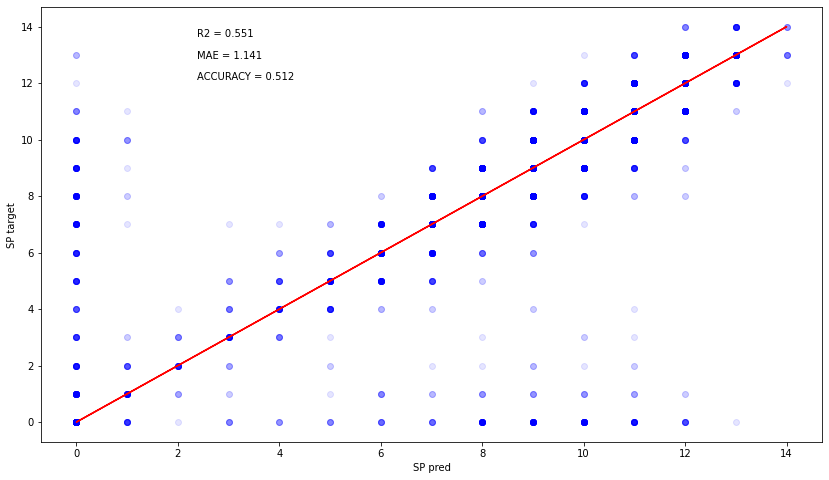

In [34]:
plt.figure(figsize=(14,8))
plt.scatter(y_pred,y_test,color='b',alpha=0.1)
plt.plot(y_pred,y_pred,color='r')
plt.xlabel('SP pred')
plt.ylabel('SP target')
plt.text(0.20, 0.95, f'R2 = {r2:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.20, 0.90, f'MAE = {mae:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.20, 0.85, f'ACCURACY = {accuracy:.3f}', transform=plt.gca().transAxes, va='top', ha='left')

plt.show()


# Let's Change the data

In [38]:
date_start = "2022-06-01"

network_metrics = pd.read_csv("./Database/network_metrics_%s.csv" % date, index_col=0)
SP = pd.read_csv("./Database/SP_60_%s.csv" % date, index_col=0)

# Use of chunk size because a problem of memory

chunk_size = 10000 
chunks_iterator = pd.read_csv("./Database/order_clean_260.csv",index_col=0, chunksize=chunk_size)
chunks=[]
for chunk in chunks_iterator:
    chunks.append(chunk)
order = pd.concat(chunks)
order["call_time"] = pd.to_datetime(order["call_time"])
order["end_time"] = pd.to_datetime(order["end_time"])
start_time = pd.to_datetime(date + " 06:00:00 AM")
end_time = pd.to_datetime(date + " 12:00:00 PM")
order_one_day = order[(order["call_time"] >= start_time) & (order["call_time"] < end_time)]

SP.columns = ["SP"]
SP = SP.reset_index(drop=True)
order_one_day = order_one_day.sort_values(by="call_time").reset_index(drop=True)
network_metrics = network_metrics.reset_index(drop=True)

# the length of the three dataframes should be the same
assert len(order_one_day) == len(network_metrics) == len(SP)

# the index of the three dataframes should be the same
assert order_one_day.index.equals(network_metrics.index) 
assert SP.index.equals(network_metrics.index)


df = pd.concat([order_one_day, network_metrics, SP], axis=1).dropna()
dh = pd.concat([order_one_day, SP], axis=1).dropna()

nodes_feature = dh[dh['call_time']<pd.to_datetime(date + " 11:00:00 AM")]

 
labels = nodes_feature.pop('SP')

# change date time into seconds between 6 am and the current time

call_list = nodes_feature["call_time"]
call_num = [int(ts.timestamp()-start_time.timestamp()) for ts in call_list]

nodes_feature[ "call_time"] = call_num

end_list = nodes_feature["end_time"]
end_num = [int(ts.timestamp()-start_time.timestamp()) for ts in end_list]

nodes_feature["end_time"] = end_num

feature_dim = 11

<ipython-input-38-9452a707b6b3>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature[ "call_time"] = call_num
<ipython-input-38-9452a707b6b3>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature["end_time"] = end_num


In [39]:
labels = labels-1
X_train, X_test, y_train, y_test = train_test_split(nodes_feature, labels, test_size=0.2, random_state=42)

In [48]:
params = {
    'objective': 'multi:softmax',  # fonction objective pour la classification multi-classe
    'num_class': 16,  # nombre de classes
    'max_depth': 9,  # profondeur maximale de l'arbre
    'learning_rate': 0.1,  # taux d'apprentissage
    'n_estimators': 1000  # nombre d'estimateurs (arbres)
}

# Entraînement du modèle
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul de l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)
r2 = r2_score(y_pred,y_test)
print("r2 score :",r2)

Accuracy: 0.5585881387235789
Mean absolute error: 0.9844038579930228
r2 score : 0.6383638757821097


In [46]:
param_grid = {
    'max_depth': [6, 9, 12,15],
    'learning_rate': [0.05,0.1, 0.3],
    'n_estimators': [300, 500, 1000]
}


xgb_model = xgb.XGBClassifier(num_class=16)


grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy')


grid_search.fit(X_train, y_train)


print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure précision:", grid_search.best_score_)

y_pred = grid_search.best_estimator_.predict(X_test)


accuracy = np.mean(y_pred == y_test)
print("Exactitude sur l'ensemble de test:", accuracy)

Meilleurs paramètres: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}
Meilleure précision: 0.5093641409714676
Exactitude sur l'ensemble de test: 0.5431972091114303


In [60]:
print(params['n_estimators'])

1000


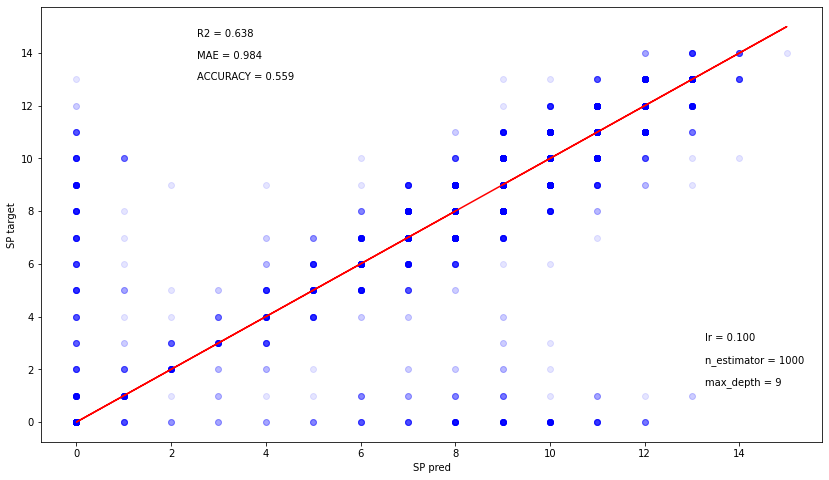

In [65]:
lr = params['learning_rate']
n_estimator = params['n_estimators']
max_depth = params['max_depth']
plt.figure(figsize=(14,8))
plt.scatter(y_pred,y_test,color='b',alpha=0.1)
plt.plot(y_pred,y_pred,color='r')
plt.xlabel('SP pred')
plt.ylabel('SP target')
plt.text(0.20, 0.95, f'R2 = {r2:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.20, 0.90, f'MAE = {mae:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.20, 0.85, f'ACCURACY = {accuracy:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.85, 0.25, f'lr = {lr:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.85, 0.20, f'n_estimator = {n_estimator}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.85, 0.15, f'max_depth = {max_depth}', transform=plt.gca().transAxes, va='top', ha='left')


plt.show()

- Change the call time by its value divide by 3600 to have a sort of hour but in float
- Try to remove end_time or replace it by the time in hour of the course 
- Maybe implement the graph in the model by adding the longest path for the current graph but I have to train my model in different parts
- To solve the problem with 0 values, maybe create several model and take the mean 

# Another try 

I removed all the informations concerning the course which are not related to the futur. This means I removed eid and call_time

In [156]:
date_start = "2022-06-01"

network_metrics = pd.read_csv("./Database/network_metrics_%s.csv" % date, index_col=0)
SP = pd.read_csv("./Database/SP_60_%s.csv" % date, index_col=0)

# Use of chunk size because a problem of memory

chunk_size = 10000 
chunks_iterator = pd.read_csv("./Database/order_clean_260.csv",index_col=0, chunksize=chunk_size)
chunks=[]
for chunk in chunks_iterator:
    chunks.append(chunk)
order = pd.concat(chunks)
order["call_time"] = pd.to_datetime(order["call_time"])
order["end_time"] = pd.to_datetime(order["end_time"])
start_time = pd.to_datetime(date + " 06:00:00 AM")
end_time = pd.to_datetime(date + " 12:00:00 PM")
order_one_day = order[(order["call_time"] >= start_time) & (order["call_time"] < end_time)]

SP.columns = ["SP"]
SP = SP.reset_index(drop=True)
order_one_day = order_one_day.sort_values(by="call_time").reset_index(drop=True)
network_metrics = network_metrics.reset_index(drop=True)

# the length of the three dataframes should be the same
assert len(order_one_day) == len(network_metrics) == len(SP)

# the index of the three dataframes should be the same
assert order_one_day.index.equals(network_metrics.index) 
assert SP.index.equals(network_metrics.index)


dz = pd.concat([order_one_day,network_metrics, SP], axis=1).dropna()

nodes_feature = dz[dz['call_time']<pd.to_datetime(date + " 11:00:00 AM")]





labels = nodes_feature.pop('SP')

# change date time into seconds between 6 am and the current time

call_list = nodes_feature["call_time"]
call_num = [(ts.timestamp()-start_time.timestamp())/3600 for ts in call_list]

nodes_feature[ "call_time"] = call_num

end_list = nodes_feature["end_time"]
end_num = [(ts.timestamp()-start_time.timestamp())/3600 for ts in end_list]



nodes_feature["end_time"] = end_num

time_left = 1 - (nodes_feature["end_time"] - nodes_feature["call_time"])

nodes_feature['time_left'] = time_left


<ipython-input-156-88a2a83fb183>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature[ "call_time"] = call_num
<ipython-input-156-88a2a83fb183>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature["end_time"] = end_num
<ipython-input-156-88a2a83fb183>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [157]:
labels = labels-1

In [163]:
try_data = nodes_feature.copy()
try_data = try_data[['eid','end_time','time_left']]
try_data.head()

,eid,end_time,time_left
0,136,0.114444,0.886111
1,225,0.164167,0.838333
2,134,0.358056,0.644444
3,157,0.072500,0.932222
4,227,0.373889,0.632500


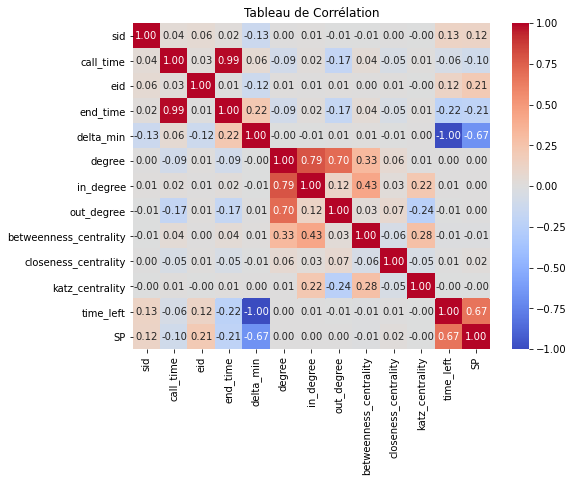

In [164]:
try_data_SP = pd.concat([nodes_feature,labels],axis=1)
correlation_matrix = try_data_SP.corr()

# Visualiser le tableau de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Tableau de Corrélation')
plt.show()

In [125]:
nodes_feature

,sid,call_time,eid,end_time,delta_min,course_time
0,158,0.000556,136,0.114444,6.833333,0.886111
1,182,0.002500,225,0.164167,9.700000,0.838333
2,138,0.002500,134,0.358056,21.333333,0.644444
3,182,0.004722,157,0.072500,4.066667,0.932222
4,136,0.006389,227,0.373889,22.050000,0.632500
...,...,...,...,...,...,...
24357,112,4.999167,72,5.201389,12.133333,0.797778
24358,128,4.999167,193,5.618611,37.166667,0.380556
24359,160,4.999444,158,5.414722,24.916667,0.584722
24360,47,4.999444,66,5.228889,13.766667,0.770556


In [165]:

X_train, X_test, y_train, y_test = train_test_split(try_data, labels, test_size=0.2, random_state=42)


In [166]:
params = {
    'objective': 'multi:softmax',  
    'num_class': 16,  # class number
    'max_depth': 9,  # max depth of each trees
    'learning_rate': 0.1,  # learning rate
    'n_estimators': 1000  # estimator number (trees)
}


model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)
r2 = r2_score(y_pred,y_test)
print("r2 score :",r2)

Accuracy: 0.5495587933511185
Mean absolute error: 0.9591627334290991
r2 score : 0.6512839355446685


Text(0.85, 0.15, 'max_depth = 9')

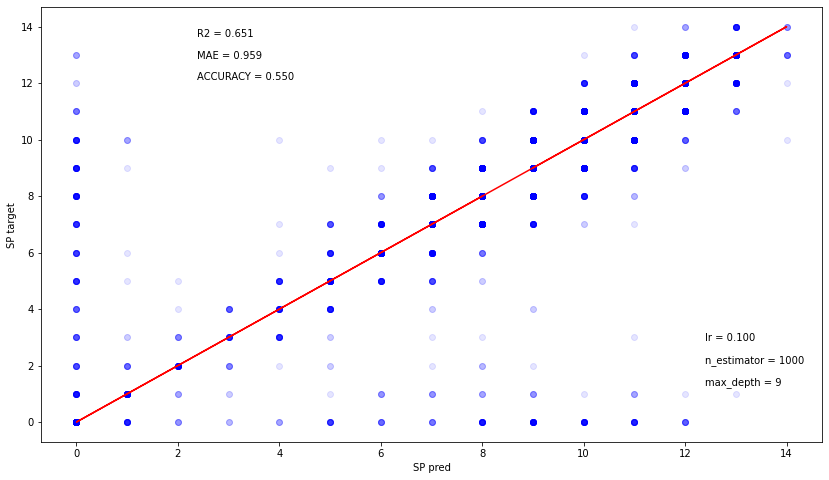

In [155]:
lr = params['learning_rate']
n_estimator = params['n_estimators']
max_depth = params['max_depth']
plt.figure(figsize=(14,8))
plt.scatter(y_pred,y_test,color='b',alpha=0.1)
plt.plot(y_pred,y_pred,color='r')
plt.xlabel('SP pred')
plt.ylabel('SP target')
plt.text(0.20, 0.95, f'R2 = {r2:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.20, 0.90, f'MAE = {mae:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.20, 0.85, f'ACCURACY = {accuracy:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.85, 0.25, f'lr = {lr:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.85, 0.20, f'n_estimator = {n_estimator}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.85, 0.15, f'max_depth = {max_depth}', transform=plt.gca().transAxes, va='top', ha='left')
plt.show()

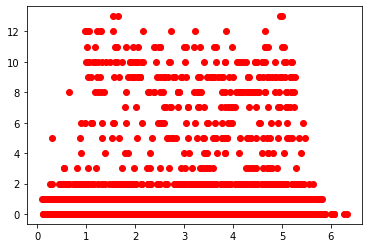

In [172]:

plt.scatter(np.array(X_test['end_time']),np.abs(np.array(y_test)-y_pred),color='r')

# Void 30 min

In [68]:
date = "2022-06-01"

network_metrics = pd.read_csv("./Database/network_metrics_%s.csv" % date, index_col=0)
SP = pd.read_csv("./Database/SP_60_30_%s.csv" % date, index_col=0)

# Use of chunk size because a problem of memory

chunk_size = 10000 
chunks_iterator = pd.read_csv("./Database/order_clean_260.csv",index_col=0, chunksize=chunk_size)
chunks=[]
for chunk in chunks_iterator:
    chunks.append(chunk)
order = pd.concat(chunks)
order["call_time"] = pd.to_datetime(order["call_time"])
order["end_time"] = pd.to_datetime(order["end_time"])
start_time = pd.to_datetime(date + " 06:00:00 AM")
end_time = pd.to_datetime(date + " 12:00:00 PM")
order_one_day = order[(order["call_time"] >= start_time) & (order["call_time"] < end_time)]

SP.columns = ["SP"]
SP = SP.reset_index(drop=True)
order_one_day = order_one_day.sort_values(by="call_time").reset_index(drop=True)
network_metrics = network_metrics.reset_index(drop=True)

# the length of the three dataframes should be the same
assert len(order_one_day) == len(network_metrics) == len(SP)

# the index of the three dataframes should be the same
assert order_one_day.index.equals(network_metrics.index) 
assert SP.index.equals(network_metrics.index)


dz = pd.concat([order_one_day,network_metrics, SP], axis=1).dropna()

nodes_feature = dz[dz['call_time']<pd.to_datetime(date + " 11:00:00 AM")]





labels = nodes_feature.pop('SP')

# change date time into seconds between 6 am and the current time

call_list = nodes_feature["call_time"]
call_num = [(ts.timestamp()-start_time.timestamp())/3600 for ts in call_list]

nodes_feature[ "call_time"] = call_num

end_list = nodes_feature["end_time"]
end_num = [(ts.timestamp()-start_time.timestamp())/3600 for ts in end_list]



nodes_feature["end_time"] = end_num

time_left = 1 - (nodes_feature["end_time"] - nodes_feature["call_time"])

nodes_feature['time_left'] = time_left


<ipython-input-68-f7a7fb77a4f3>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature[ "call_time"] = call_num
<ipython-input-68-f7a7fb77a4f3>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature["end_time"] = end_num
<ipython-input-68-f7a7fb77a4f3>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [69]:
labels = labels-1

In [70]:
try_data = nodes_feature.copy()
try_data = try_data[['eid','end_time','time_left']]
try_data.head()

,eid,end_time,time_left
0,136,0.114444,0.886111
1,225,0.164167,0.838333
2,134,0.358056,0.644444
3,157,0.072500,0.932222
4,227,0.373889,0.632500


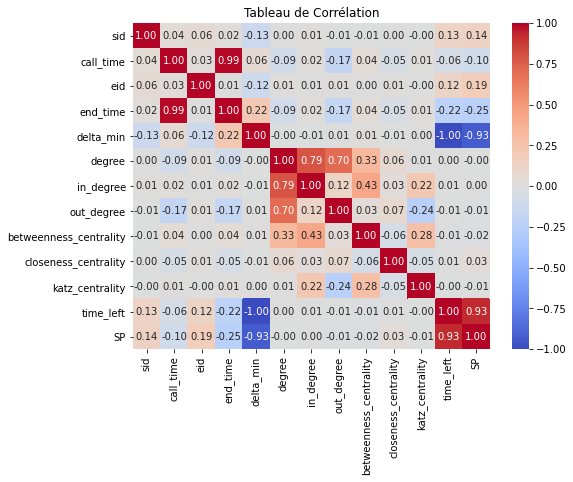

In [71]:
try_data_SP = pd.concat([nodes_feature,labels],axis=1)
correlation_matrix = try_data_SP.corr()

# Visualiser le tableau de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Tableau de Corrélation')
plt.show()

In [72]:

X_train, X_test, y_train, y_test = train_test_split(try_data, labels, test_size=0.2, random_state=42)

In [11]:
param_grid = {
    'max_depth': [9],
    'learning_rate': [0.05,0.1, 0.3],
    'n_estimators': [1000]
}


xgb_model = xgb.XGBClassifier(num_class=16)


grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy')


grid_search.fit(X_train, y_train)


print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure précision:", grid_search.best_score_)

y_pred = grid_search.best_estimator_.predict(X_test)


accuracy = np.mean(y_pred == y_test)
print("Exactitude sur l'ensemble de test:", accuracy)

Meilleurs paramètres: {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 1000}
Meilleure précision: 0.556211004169412
Exactitude sur l'ensemble de test: 0.5834188384978453


In [73]:
params = {
    'objective': 'multi:softmax',  
    'num_class': 16,  # class number
    'max_depth': 9,  # max depth of each trees
    'learning_rate': 0.05,  # learning rate
    'n_estimators': 1000  # estimator number (trees)
}


model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)
r2 = r2_score(y_pred,y_test)
print("r2 score :",r2)

Accuracy: 0.5834188384978453
Mean absolute error: 0.4541350297557972
r2 score : 0.9300441171880995


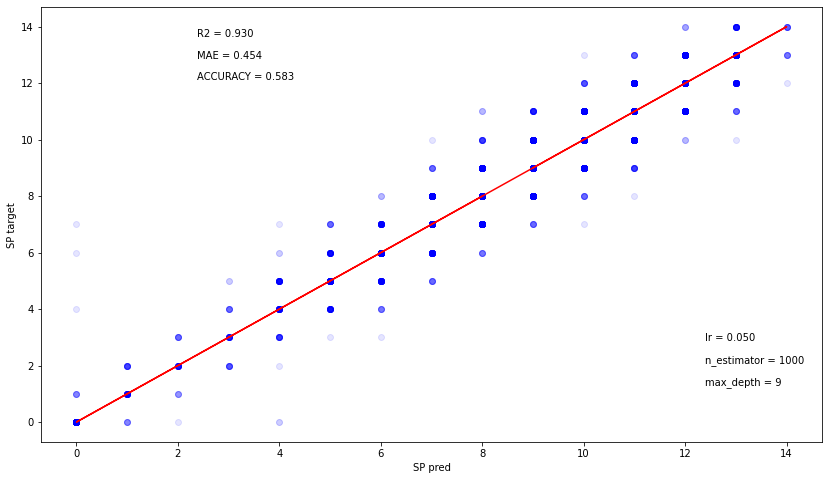

In [74]:
lr = params['learning_rate']
n_estimator = params['n_estimators']
max_depth = params['max_depth']
plt.figure(figsize=(14,8))
plt.scatter(y_pred,y_test,color='b',alpha=0.1)
plt.plot(y_pred,y_pred,color='r')
plt.xlabel('SP pred')
plt.ylabel('SP target')
plt.text(0.20, 0.95, f'R2 = {r2:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.20, 0.90, f'MAE = {mae:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.20, 0.85, f'ACCURACY = {accuracy:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.85, 0.25, f'lr = {lr:.3f}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.85, 0.20, f'n_estimator = {n_estimator}', transform=plt.gca().transAxes, va='top', ha='left')
plt.text(0.85, 0.15, f'max_depth = {max_depth}', transform=plt.gca().transAxes, va='top', ha='left')
plt.show()

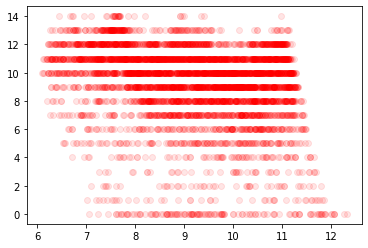

In [24]:
plt.scatter(np.array(X_test['end_time']+6),np.array(y_test),color='r',alpha=0.1,norm=0.01)

# Predict the next day with the model

In [80]:
data_02, target_02 = load_data(date = "2022-06-02")

<ipython-input-77-05ed52e2fff8>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature[ "call_time"] = call_num
<ipython-input-77-05ed52e2fff8>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature["end_time"] = end_num
<ipython-input-77-05ed52e2fff8>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

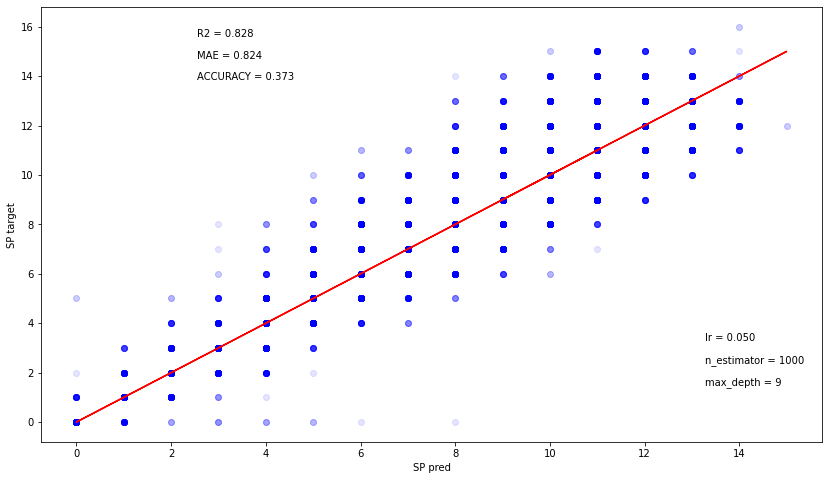

In [79]:
plot_results(model,data_02,target_02)

# Train on 2 days and see the results

In [81]:
data_01 , label_01 = load_data(date = '2022-06-01')
data_02 , label_02 = load_data(date='2022-06-02')

data = pd.concat([data_01,data_02])
data.reset_index(drop=True, inplace=True)

label = pd.concat([label_01,label_02])
label.reset_index(drop=True, inplace=True)

<ipython-input-77-05ed52e2fff8>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature[ "call_time"] = call_num
<ipython-input-77-05ed52e2fff8>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_feature["end_time"] = end_num
<ipython-input-77-05ed52e2fff8>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [82]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [85]:
params = {
    'objective': 'multi:softmax',  
    'num_class': 16,  # class number
    'max_depth': 9,  # max depth of each trees
    'learning_rate': 0.1,  # learning rate
    'n_estimators': 1000  # estimator number (trees)
}


model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, num_class=16,
              num_parallel_tree=None, ...)

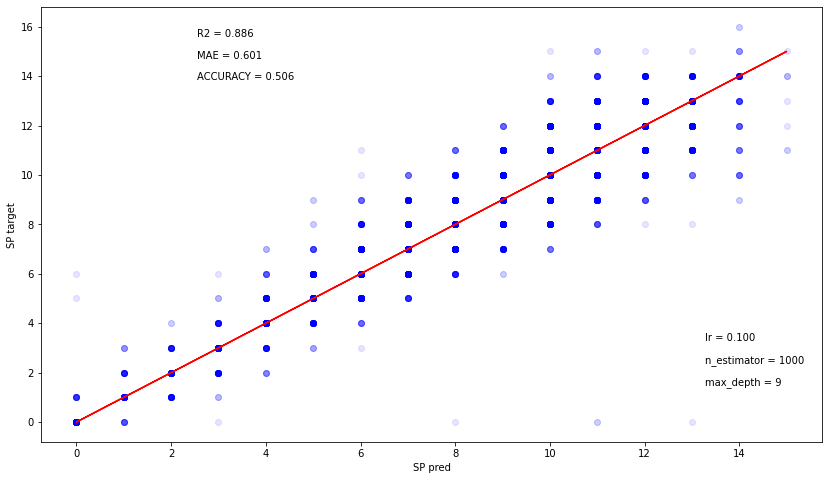

In [86]:
plot_results(model,X_test,y_test)